# IEOR 265 Course Project
### by Hyungki Im, Tor Nitayanont, and Sean Seung Joo Lee

This project explores using learning techniques to play the popular game 2048 and compares play performance against two benchmark models. This notebook includes all scripts needed to run the algorithms. The contents are as follows:
- Tools to play the game 2048
- Algorithms and heuristics used to play the game
- Codes to run algorithms and generate metrics to compare performance

## Scripts to Play 2048
The following codes are all the codes that are needed to play the game. 

In [34]:
# This script builds all the mechanics needed to play the 2048 game

import numpy as np
import copy as cp
from numpy import zeros
import matplotlib.pyplot as plt

class board_game_2048():
    def __init__(self):
        self.board = zeros((4,4),dtype=np.int)
        self.game_over = False
        
    def move(self,direction):
        pass
    def is_game_over(self):
        pass

game = board_game_2048()

from random import randint, random

def fill_cell(board):
    i,j = (board == 0).nonzero()
    if i.size != 0:
        rnd = randint(0,i.size-1)
        board[i[rnd],j[rnd]]=2*((random()>.9)+1)

fill_cell(game.board)

from numpy import array, zeros

def move_left(col):
    new_col = zeros((4), dtype=col.dtype)
    j = 0
    previous = None
    for i in range(col.size):
        if col[i] != 0: # number different from zero
            if previous == None:
                previous = col[i]
            else:
                if previous == col[i]:
                    new_col[j] = 2 * col[i]
                    j += 1
                    previous = None
                else:
                    new_col[j] = previous
                    j += 1
                    previous = col[i]
    if previous != None:
        new_col[j] = previous
    return new_col

from numpy import rot90

def move(board, direction):
    # 0: left, 1: up, 2: right, 3: down
    rotated_board = rot90(board, direction)
    cols = [rotated_board[i, :] for i in range(4)]
    new_board = array([move_left(col) for col in cols])
    return rot90(new_board, -direction)

def main_loop(board, direction):
    new_board = move(board, direction)
    moved = False
    if (new_board == board).all():
        # move is invalid
        pass
    else:
        moved = True
        fill_cell(new_board)
        
    return (new_board)

def game_end(board):
    ended=True
    for m in range(4):
        new_board=move(board,m)
        if (new_board == board).all()==False:
            ended=False
            
    return ended

In [24]:
# Example Script to play two stages of the game

# Initialize the board
game = board_game_2048()
fill_cell(game.board)
board = game.board
print('Initial Board')
print(board)

# The action set is as follows --> 0: left, 1: up, 2: right, 3: down

# Play First Move: Play Left
newboard1 = main_loop(board,0)
print('Board after one move Left:')
print(newboard1)

# Play Second Move: Play Up
newboard2 = main_loop(newboard1,1)
print('Board after one move up:')
print(newboard2)

Initial Board
[[0 0 0 0]
 [0 0 0 2]
 [0 0 0 0]
 [0 0 0 0]]
Board after one move Left:
[[0 0 0 0]
 [2 0 0 0]
 [0 0 2 0]
 [0 0 0 0]]
Board after one move up:
[[2 2 2 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]


## Defining the Algorithms

We define functions that will play the algorithms until the game ends

#### Naive Strategy:
This script uses the tools built above to execute a strategy of choosing the action that will minimize the number of pieces on the board in the next turn. Note that at each turn, exactly one random piece is generated. Thus, the number of pieces on the board in the next turn is deterministic. 

In [2]:
def one_step_min_pieces():
    game = board_game_2048()
    fill_cell(game.board)
    board = game.board

    i = 0
    game_end_flag = 0
    while game_end_flag == 0:
        game_end_flag = 1
        winning_count = 20 # initialize winning count to be very high
        newboard = main_loop(board,0)
        count0 = np.count_nonzero(newboard)
        if (newboard != board).any():
            m = 0
            winning_count = count0
            game_end_flag = 0
        newboard = main_loop(board,1)
        count1 = np.count_nonzero(newboard)
        if count1<winning_count and (newboard != board).any(): 
            m = 1
            winning_count = count1
            game_end_flag = 0
        newboard = main_loop(board,2)
        count2 = np.count_nonzero(newboard)
        if count2<winning_count and (newboard != board).any():
            m = 2
            winning_count = count2
            game_end_flag = 0
        newboard = main_loop(board,3)
        count3 = np.count_nonzero(newboard)
        if count3<winning_count and (newboard != board).any():
            m = 3
            winning_count = 3
            game_end_flag = 0

        board = main_loop(board,m)
        i = i + 1
    return(board)


In [28]:
# Example Run
board = one_step_min_pieces() 
print(board)

[[256 128  64  16]
 [128  64  32   8]
 [  4  32  16   2]
 [  2   8   2   4]]


#### Random Play
This code plays the game with random moves until the game ends. 

In [3]:
# This script demonstrates complete random play
def rand_play():
    game = board_game_2048()
    fill_cell(game.board)
    board = game.board

    game_end_flag = 0
    i = 0
    while game_end_flag == 0:
        game_end_flag = 1
        for j in range(4):
            if (main_loop(board,j) != board).any():
                game_end_flag = 0
        m = randint(0,3)
        board = main_loop(board,m)
        i = i+1
    return(board)

In [29]:
# Example Run
board = rand_play()
print(board)

[[  8   2  64   2]
 [  2   8  32   8]
 [ 16 128   2  16]
 [  4   2  16   4]]


#### Monte Carlo Tree Search
This code considers each direction and simulates taking one step in that direction followed by a hundred random steps. The simulation is repeated ten times. The direction that has on average the highest score in those simulations is chosen as the optimal direction. 

In [30]:
def rand_play_rounds(its,board):
    game_end_flag = 0
    i = 0
    while i <= its:
        m = randint(0,3)
        board = main_loop(board,m)
        i = i+1
    return(board)

# Random Play Base Policy Trajectory Method

def rand_traj():
    game = board_game_2048()
    fill_cell(game.board)
    board = game.board
    i = 0
    while game_end(board)==False:
        s = 0
        # for each direction, take one step and then 100 random steps
        # choose the direction that results in the largest score
        for y in range(4):
            newboard1 = main_loop(board,y)
            score = []
            for q in range(10):
                newboard = rand_play_rounds(100,newboard1)
                score = np.append(score, np.sum(newboard))
            score = np.sum(score)
            if score > s and (newboard1!=board).any():
                s = score
                c = y
        board = main_loop(board,c)
        i = i+1

    return(board)


In [31]:
# Example Run
board = rand_traj()
print(board)

[[   2    8    2    8]
 [  64    4  128   16]
 [   4    8 1024    2]
 [   2   16  512    8]]


#### L-Step Look Ahead Methods
These codes are used to generate the cost-to-go-function and the L-step lookahead algorithm

In [35]:

#Defining cost-to-go function here
def Score(board, score_option):
    if score_option == "sum":
        if game_end(board)==True:
            return 0
        else:
            score=np.sum(board)
        return score
    elif score_option == "max":
        if game_end(board)==True:
            return 0
        else:
            score=np.amax(board)
        return score
    elif score_option == "weight":
        if game_end(board)==True:
            return 0
        else:
            score = np.sum(board) + 2*board[0,0] + 1*(board[1,0]+board[0,1]) + 0.5*(board[2,0]+board[1,1]+board[0,2])
        return score

# L-step lookahed
#direction=[0,0,0,0,0,0]


#Input: Sequence of actions, This returns expected value of our sequence.
def L_stepLA(board, L, direction, iter_count, score_option):
    TS=0
    
    if iter_count<L:
        m=direction[iter_count]
        new_board=move(board,m)
        if (new_board != board).any():
            
            #We have at most 4 possible actions
            num_zero=np.count_nonzero(new_board==0)
            zero_list=np.where(new_board==0)
            for k in range(num_zero):
                for p in range(2): #we can have 2 or 4 in an empty tile
                    if p==0: #number 2 pops up
                        temp=np.copy(new_board)
                        i=zero_list[0][k]
                        j=zero_list[1][k]
                        temp[i,j]=2
                        score=0.9*L_stepLA(temp,L,direction,iter_count+1, score_option)/num_zero
                        TS+=score
                    else:
                        temp=np.copy(new_board)
                        i=zero_list[0][k]
                        j=zero_list[1][k]
                        temp[i,j]=4
                        score=0.1*L_stepLA(temp,L,direction,iter_count+1, score_option)/num_zero
                        TS+=score
            return TS
        else:
            return 0
                        
    else:
        TS=Score(board, score_option)
        return TS
    
def generate_sequence(L):
    seq = []
    if L == 1:
        seq = [[0],[1],[2],[3]]
        return seq
    else:
        temp_seq = generate_sequence(L-1)
        for s in temp_seq:
            for i in range(4):
                s_copy = cp.copy(s)
                s_copy.append(i)
                seq.append(s_copy)
        return seq
    
def optimal_action(board, L, score_option):
    all_seq = generate_sequence(L)
    list_sc = [0 for i in range(len(all_seq))]
    ind_argmax = -1
    current_max = -1
    for i in range(len(all_seq)):
        seq = all_seq[i]
        sc = L_stepLA(board, L, seq, 0, score_option)
        list_sc[i] = sc
        if sc > current_max:
            current_max = sc
            ind_argmax = i
    return all_seq[ind_argmax]

# Weight Function Call
def weight():
    game = board_game_2048()
    fill_cell(game.board)
    board = game.board

    L = 2

    i = 0

    while not game_end(board):
        action_seq = optimal_action(board,L,"weight")
        opt_action = action_seq[0]
        new_board = move(board, opt_action)
        fill_cell(new_board)
        board = np.copy(new_board)
        i = i+1
    return(board)

# Sum Function Call
def sume():
    game = board_game_2048()
    fill_cell(game.board)
    board = game.board

    L = 2

    i = 0

    while not game_end(board):
        action_seq = optimal_action(board,L,"sum")
        opt_action = action_seq[0]
        new_board = move(board, opt_action)
        fill_cell(new_board)
        board = np.copy(new_board)
        i = i+1
    return(board)

# Max Function Call
def maxe():
    game = board_game_2048()
    fill_cell(game.board)
    board = game.board

    L = 2

    i = 0

    while not game_end(board):
        action_seq = optimal_action(board,L,"max")
        opt_action = action_seq[0]
        new_board = move(board, opt_action)
        fill_cell(new_board)
        board = np.copy(new_board)
        i = i+1
    return(board)

In [36]:
# Example Run
board = weight()
print(board)

[[1024   64    8    4]
 [ 512  128   32    8]
 [  32   64   16    4]
 [   2   16    8    2]]


## Evaluate the Algorithms
These scripts will run each of the algorithms and generate metrics used to compare performance. 
it_num determines the number of runs to perform before generating metrics

567.9
236.16
[[ 510.  642.  412.  400.  788.  520.  536.  756. 1092.  594.  920.  920.
   388.  700.  316.  644.  408.  314.  598. 1304.  410.  460.  632.  576.
   352.  492.  718.  336. 1224.  702.  400.  414.  876.  508. 1134.  586.
   486.  666.  606.  860.  656.  536.  578.  580.  492.  408.  486.  674.
   526.  574.  518.  410.  632.  348.  758.  652.  732.  480.  480.  678.
   468.  274.  326.  614.  712.  438.  568.  638.  170.  910.  278.  502.
   380.  520.  440.  484.  550.  458.  406.  636.  366.  446.  758.  514.
   332.  428.  528.  594.  560.  474.  408.  644.  864.  752.  422.  712.
   332.  240.  724.  522.]]
[[ 128.  256.  256.  128.  256.  128.  256.  256.  512.  256.  512.  512.
   128.  256.  128.  256.  128.   64.  256. 1024.  128.  128.  256.  128.
   128.  128.  512.  128.  512.  256.  128.  128.  512.  256.  512.  256.
   256.  256.  256.  256.  256.  128.  256.  256.  256.  128.  128.  256.
   128.  256.  256.  128.  256.  128.  512.  256.  256.  256.  256.  25

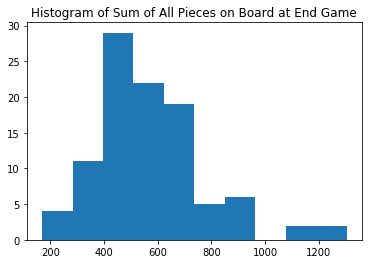

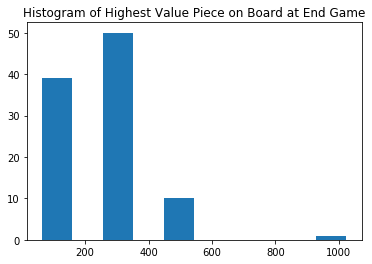

In [41]:
# Evaluate the Naive Strategy
import time
start = time.time()
it_num = 100
scores_sum = np.zeros([it_num,1])
scores_max = np.zeros([it_num,1])
for i in range(it_num):
    board = one_step_min_pieces()
    s_sum = np.sum(board)
    s_max = np.amax(board)
    scores_sum[i]=s_sum
    scores_max[i]=s_max
print(np.mean(scores_sum))
print(np.mean(scores_max))
print(scores_sum.T)
print(scores_max.T)
plt.figure(1)
plt.title('Histogram of Sum of All Pieces on Board at End Game')
plt.hist(scores_sum)
plt.figure(2)
plt.title('Histogram of Highest Value Piece on Board at End Game')
plt.hist(scores_max)
end = time.time()
dur = end-start
print('Duration: ',dur)

258.44
100.8
[[132. 208. 328. 190. 180. 324. 226. 166. 322. 118. 326. 114. 330. 324.
  252. 284. 250. 334. 312. 158. 240. 416. 180. 318. 236. 210. 214. 262.
  192. 434. 258. 196. 294. 174. 322. 204. 420. 284. 222. 220. 188. 202.
  214. 252. 324. 324. 286. 180. 192. 180. 336. 196. 228. 162. 184. 250.
  148. 334. 348. 306. 200. 190. 206. 216. 434. 304. 228. 332. 234. 324.
  340. 160. 250. 242. 190. 352. 404. 426. 162. 192. 216. 262. 340. 248.
  302. 272. 130. 270. 268. 136. 318. 218. 244. 218. 282. 496. 204. 226.
  538. 262.]]
[[ 32.  64. 128.  64.  64. 128.  64.  64. 128.  32. 128.  32. 128. 128.
  128. 128. 128. 128. 128.  64.  64. 256.  64. 128.  64.  64.  64. 128.
   64. 256.  64.  64. 128.  64. 128.  64. 256. 128.  64.  64.  64.  64.
   64. 128. 128. 128. 128.  32.  64.  64. 128.  64.  64.  32.  64. 128.
   32. 128. 128. 128.  64.  64.  64.  64. 256. 128.  64. 128. 128. 128.
  128.  32.  64.  64.  64. 128. 256. 128.  64.  64.  64.  64. 128.  64.
  128. 128.  32. 128. 128.  32. 128. 

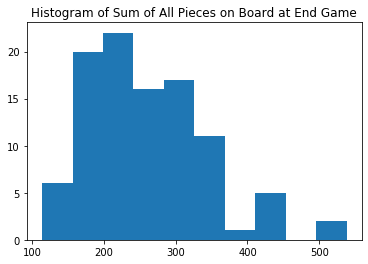

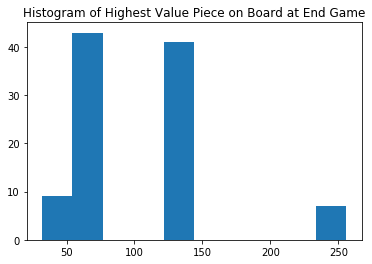

In [42]:
# Evaluate Random Play Strategy
import time
start = time.time()
it_num = 100
scores_sum = np.zeros([it_num,1])
scores_max = np.zeros([it_num,1])
for i in range(it_num):
    board = rand_play()
    s_sum = np.sum(board)
    s_max = np.amax(board)
    scores_sum[i]=s_sum
    scores_max[i]=s_max
print(np.mean(scores_sum))
print(np.mean(scores_max))
print(scores_sum.T)
print(scores_max.T)
plt.figure(1)
plt.title('Histogram of Sum of All Pieces on Board at End Game')
plt.hist(scores_sum)
plt.figure(2)
plt.title('Histogram of Highest Value Piece on Board at End Game')
plt.hist(scores_max)
end = time.time()
dur = end-start
print('Duration: ',dur)

In [185]:
# Evaluate MCTS Heuristic
import time
start = time.time()
it_num = 100
scores_sum = np.zeros([it_num,1])
scores_max = np.zeros([it_num,1])
for i in range(it_num):
    board = rand_traj()
    s_sum = np.sum(board)
    s_max = np.amax(board)
    scores_sum[i]=s_sum
    scores_max[i]=s_max
print(np.mean(scores_sum))
print(np.mean(scores_max))
print(scores_sum.T)
print(scores_max.T)
plt.figure(1)
plt.title('Histogram of Sum of All Pieces on Board at End Game')
plt.hist(scores_sum)
plt.figure(2)
plt.title('Histogram of Highest Value Piece on Board at End Game')
plt.hist(scores_max)
end = time.time()
dur = end-start
print('Duration: ',dur)

486.22


In [ ]:
# Evaluate L-Step Lookahead
import time
start = time.time()
it_num = 100
scores_sum = np.zeros([it_num,1])
scores_max = np.zeros([it_num,1])
for i in range(it_num):
    board = sume() #weight #maxe
    s_sum = np.sum(board)
    s_max = np.amax(board)
    scores_sum[i]=s_sum
    scores_max[i]=s_max
print(np.mean(scores_sum))
print(np.mean(scores_max))
print(scores_sum.T)
print(scores_max.T)
plt.figure(1)
plt.title('Histogram of Sum of All Pieces on Board at End Game')
plt.hist(scores_sum)
plt.figure(2)
plt.title('Histogram of Highest Value Piece on Board at End Game')
plt.hist(scores_max)
end = time.time()
dur = end-start
print('Duration: ',dur)